In [5]:
import sys
sys.path.append('../../../Utils')

import os 
from data_feed import DataFeed
datafeed = DataFeed(config_path=os.path.join('../..', 'config.ini'),
                    local_data_dir='../../data')

## 沪深 300 指数的收益率时间序列
- (2005.04.08 - 2012.07.31)收益率（涨跌幅）时间序列

In [6]:
""" 读取本地数据 """
daily_300idx = datafeed.load_local_data('000300.XSHG', 'daily')
print(daily_300idx.shape)
daily_300idx.head()

数据加载完成~ 
first_dt:2005-04-08 23:59:59, 
last_dt:2022-01-28 23:59:59
(4090, 8)


,open,close,high,low,volume,money,date,time
0,984.66,1003.45,1003.70,979.53,1.476253e+09,9.151350e+09,2005-04-08,23:59:59
1,1003.88,995.42,1008.74,992.77,1.593607e+09,1.043623e+10,2005-04-11,23:59:59
2,993.71,978.70,993.71,978.20,1.022619e+09,6.479563e+09,2005-04-12,23:59:59
3,987.95,1000.90,1006.50,987.95,1.607169e+09,1.002960e+10,2005-04-13,23:59:59
4,1004.64,986.98,1006.42,985.58,1.294571e+09,7.813425e+09,2005-04-14,23:59:59


In [7]:
samp_data = daily_300idx[daily_300idx['date']<='2012-07-31']
samp_data['chg_pct'] = samp_data['close']/samp_data['close'].shift(1)-1
samp_data.loc[0, 'chg_pct'] = samp_data['close'][0]/samp_data['open'][0]-1
r_series = samp_data['chg_pct']
r_series

<ipython-input-7-1ff67cfd06d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_data['chg_pct'] = samp_data['close']/samp_data['close'].shift(1)-1
C:\Users\xuezhihuan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0       0.019083
1      -0.008002
2      -0.016797
3       0.022683
4      -0.013907
          ...   
1774   -0.006696
1775   -0.005335
1776    0.000690
1777   -0.005670
1778   -0.001229
Name: chg_pct, Length: 1779, dtype: float64

# 相关函数定义

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [9]:
def get_CC_S_results(data, t):
    """
        计算得到C-C法下需要确定最优时间延迟所需要的数据 
    """
    data_std = data.std()
    N = len(data)
    
    m_lst = [2,3,4,5]
    j_lst = [1,2,3,4]
        
    # 计算不同（m,j）组合下的S
    S_res_df = pd.DataFrame(index=m_lst, columns=j_lst)
    params = [(m,j) for m in m_lst for j in j_lst]
    for (m,j) in tqdm(params):
        r = j/2 * data_std
        s = calc_S(m, data, r, t)
        S_res_df.loc[m, j] = s
    
    # 求全部（m，j）组合下，S的均值
    s_mean = S_res_df.values.mean()
    deltas_mean = (S_res_df.max(axis=1)-S_res_df.min(axis=1)).mean()
    s_cos = abs(s_mean) + deltas_mean
    return S_res_df, s_mean, deltas_mean, s_cos

def get_restruct_data(data, m, t):
    """ 
        重构相空间
        data - 一维时间序列
        m    - 嵌入维数
        t    - 时间延迟
    """
    N = len(data)
    M = N - (m-1) * t
    
    restruct_data = np.ones(shape=(M, m)) # shape:(M,m)
    for i in range(M):
        restruct_data[i] = data[i: i+(m-1)*t+1][::t]
    return restruct_data

def calc_C(m, data, r, t, restruct_data=None):
    """ 
        关联积分C计算函数：
            input params：
                data - 时间序列数据
                m    - 嵌入维数
                t    - 时间延迟
                r    - 原始data的标准差的倍数
                restruct_data - 重构相空间后数据，若已传入，则不需用 data, m, t 计算
    """
    if restruct_data is None:
        restruct_data = get_restruct_data(data, m, t)        # shape = (M, m)
    
    # 根据restruct_data计算关联积分
    sum_c = 0
    for i in range(len(restruct_data)):
        # 第i   个行向量
        arr_i = restruct_data[i]
        # 第i~M 个行向量
        arr_js = restruct_data[i+1:]
        # 计算两两向量之差的无穷范数
        inf_norm = abs(arr_i - arr_js).max(axis=1)
        # 无穷范数小于等于r，=1，否则=0
        sum_c += sum(inf_norm <= r)
    
    M = len(data)-(m-1)*t
    return 2 * sum_c / (M*(M-1))

def calc_S(m, data, r, t):
    """ 
        r - 始data的标准差的倍数
        t - 时间延迟
    
        计算 S(m,N=len(data),r,t) 的期望：
        1. 根据给定的t，将data划分为相空间中t组互不相交的子时间序列
        2. 等于各子时间序列的 【C(m, N=len(data)/t, r, t) - C^m(1, N=len(data)/t, r, t)】的均值
    """
    N = len(data)
    
    # 1. 生成t个子序列, 每个子序列length=N//t
    need_data = data[:N//t*t]
    son_datas = [need_data[i::t] for i in range(t)]
    
    # 2. 计算每个子序列的  C(m, N, r,t) - C^m(1, N, r, t),
    Ss = [calc_C(m, son_data, r, t) - calc_C(1, son_data, r, t)**m for son_data in son_datas]
    
    # 3. 求全部子序列计算出S的均值，作为S的期望
    s = np.mean(Ss)
    return s


# 沪深300日线的CC法应用

## 确定最优 时间延迟（t）和嵌入维数（m）

In [18]:
S_res_lst = []
for t in range(1,21,1):
    S_res_df, s_mean, deltas_mean, s_cos = get_CC_S_results(r_series, t=t)
    S_res_lst.append((t, s_mean, deltas_mean, s_cos))

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


In [20]:
pd.DataFrame(S_res_lst, columns=['t', 'S_mean', 'deltaS_mean', 'S_cos'])

,t,S_mean,deltaS_mean,S_cos
0,1,0.022414,0.031615,0.054028
1,2,0.025784,0.034073,0.059857
2,3,0.017882,0.023789,0.041671
3,4,0.013781,0.018002,0.031784
4,5,0.011661,0.015794,0.027455
5,6,0.009348,0.012674,0.022022
6,7,0.006787,0.008614,0.015401
7,8,-0.000834,0.012902,0.013736
8,9,-0.004672,0.021271,0.025944
9,10,-0.010732,0.023299,0.034031


In [21]:
# S_Cov最小值出现在7，所以延迟时间窗口=7
# S_mean的第一个零点或deltaS_mean的第一个极小值出现在7， 所以最优时间延迟=7 
# 根据公式: t_window = (m-1) * t
t_window=7
best_t = 7

m = t_window/best_t+1
m 

2.0

## FFT求信号平均周期

In [89]:
y = np.array(r_series)
y

array([ 0.01908273, -0.00800239, -0.01679693, ...,  0.0006901 ,
       -0.00567023, -0.00122871])

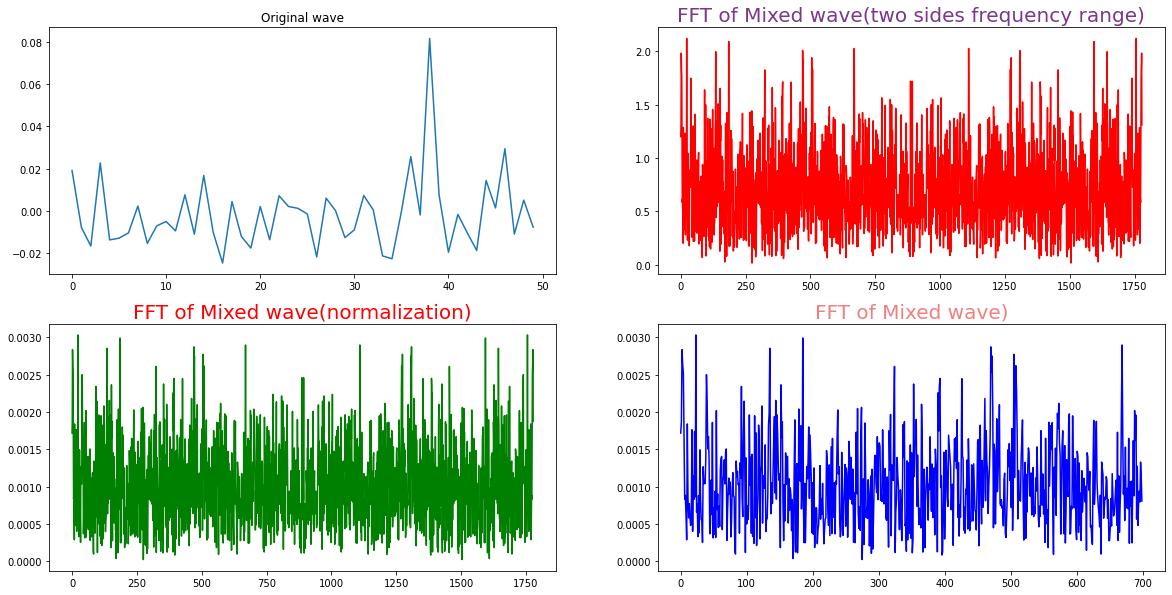

In [90]:

yy=fft(y)       #快速傅里叶变换
yreal = yy.real # 获取实数部分
yimag = yy.imag # 获取虚数部分

yf=abs(fft(y))                   # 取模
yf1=abs(fft(y))/((len(x)/2))     #归一化处理
yf2 = yf1[range(int(len(x)/2))]  #因为对称性，只取一半区间

xf = np.arange(len(y))          # 频率
xf1 = xf
xf2 = xf[range(int(len(x)/2))]  #取一半区间

plt.figure(figsize=(20, 10))

#原始波形 Sample
plt.subplot(221)
plt.plot(xf[0:50], y[0:50])
plt.title('Original wave')

# 混合波 FFT（双边频率范围）
plt.subplot(222)
plt.plot(xf, yf,'r') #显示原始信号的FFT模值
plt.title('FFT of Mixed wave(two sides frequency range)',fontsize=20, color='#7A378B')  #注意这里的颜色能够查询颜色代码表

# 混合波 FFT（归一化）
plt.subplot(223)
plt.plot(xf1, yf1,'g')
plt.title('FFT of Mixed wave(normalization)',fontsize=20,color='r')

# 取一半区间
plt.subplot(224)
plt.plot(xf2, yf2, 'b')
plt.title('FFT of Mixed wave)',fontsize=20,color='#F08080')

plt.show()

In [98]:
np.argmax(yf2)

23

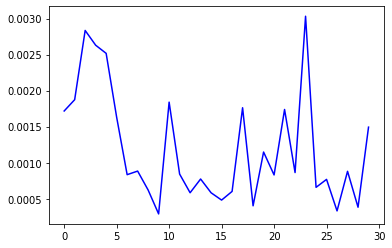

In [109]:
plt.plot(xf2[:30], yf2[:30], 'b')
plt.show()

## 求Lyapunov 指数
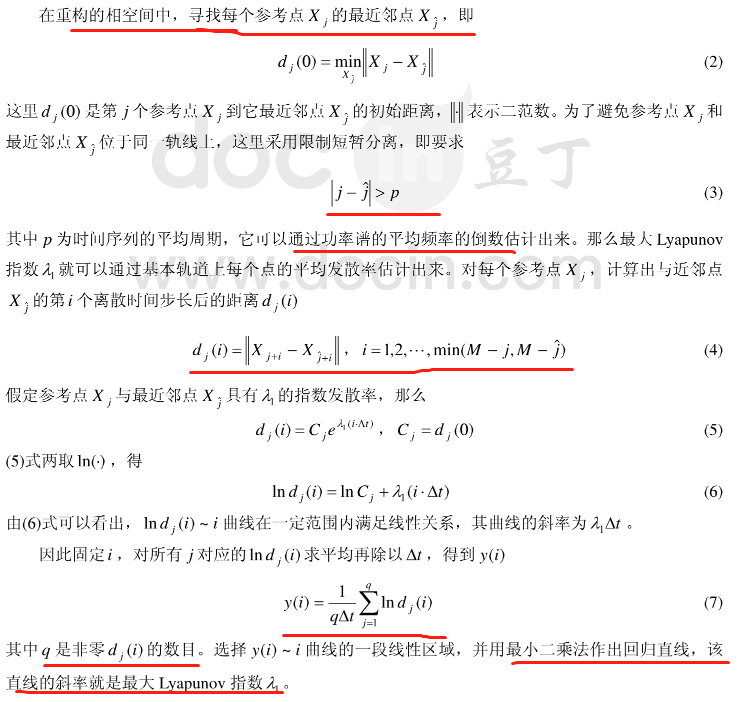

### 自己定义

In [10]:
def get_dji_arr(restruct_data, mean_window):
    """  计算dj0~dji，
         及每个Xj的最临近点的坐标 
    """
    M = len(restruct_data)
    dji_arr = np.nan * np.ones(shape=(M, M-1))
    min_dist_idx_arr = np.ones(shape=(M,))
    for j in range(M):
        # 计算 restruct_data[i] 和所有 行向量的距离
        dist_arr = np.linalg.norm((restruct_data - restruct_data[j]), ord=2, axis=1, keepdims=True)
        
        # 距离从小到大排列，对应的行向量序号
        dist_asc_idxes = dist_arr.flatten().argsort()
        
        # idx 不在（i-mean_window, i+mean_window）
        q_dist_asc_idxes = dist_asc_idxes[(dist_asc_idxes<j-mean_window)|(dist_asc_idxes>j+mean_window)]
        
        # q_min_dist_idx - Xj最临界点的坐标， q_min_dist - Xj最临近点距离
        q_min_dist_idx = q_dist_asc_idxes[0]
        
        # 计算Xj对应的dj0~dji的值
        max_shift = min(M-j-1, M-q_min_dist_idx-1)        
        dji = np.linalg.norm(restruct_data[j: j+max_shift] - restruct_data[q_min_dist_idx: q_min_dist_idx+max_shift], ord=2, axis=1, keepdims=True).flatten()
        
        # 赋值到dji_arr上
        dji_arr[j][:len(dji)] = dji
        min_dist_idx_arr[j] = q_min_dist_idx
        
        # 填0为nan
        dji_arr[dji_arr==0]=np.nan
    return dji_arr, min_dist_idx_arr

In [49]:
m_choice = 2
t_choice = 7
mean_window_choice = 10

restruct_r_series = get_restruct_data(r_series, m=m_choice, t=t_choice)
dji_arr, min_dist_idx_arr = get_dji_arr(restruct_r_series, mean_window=mean_window_choice)
ln_dji_arr = np.log(dji_arr)
ln_dji_mean = np.nanmean(ln_dji_arr, axis=0, dtype=np.float64)
ln_dji_mean

<ipython-input-49-e34d9d6515d2>:8: RuntimeWarning: Mean of empty slice
  ln_dji_mean = np.nanmean(ln_dji_arr, axis=0, dtype=np.float64)


array([-7.18179204, -3.6898055 , -3.69994278, ...,         nan,
               nan,         nan])

[ 2.30914802e-04 -3.64500861e+00]


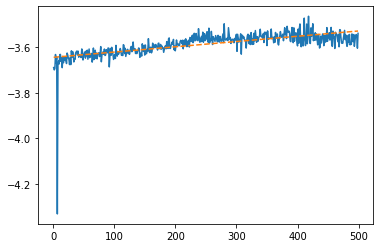

In [56]:
import matplotlib.pyplot as plt

fit_period = 500 # i~dj(i)用多少期做拟合 

t = np.array(np.arange(1, fit_period, 1))
x = np.array(ln_dji_mean[1:fit_period])

params = np.polyfit(t, x, 1)

print(params)

plt.plot(t, x)
plt.plot(t, params[1] +params[0]* t, '--', label='fit function')

plt.show()

[-0.0182445  -3.65299393]


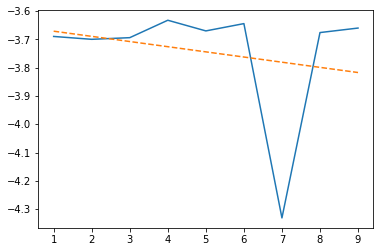

In [57]:
import matplotlib.pyplot as plt

fit_period = 10 # i~dj(i)用多少期做拟合 

t = np.array(np.arange(1, fit_period, 1))
x = np.array(ln_dji_mean[1:fit_period])

params = np.polyfit(t, x, 1)

print(params)

plt.plot(t, x)
plt.plot(t, params[1] +params[0]* t, '--', label='fit function')

plt.show()

### 调包（nolitsa）

In [32]:
import warnings
from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

In [35]:
x = get_restruct_data(r_series, m=2, t=7)

# Choose appropriate Theiler window.
meanperiod = 10
maxt = 500

d = lyapunov.mle(x, maxt=maxt, window=meanperiod)
t = np.arange(maxt)

coefs = np.polyfit(t, d, 1)
print('LLE = ', coefs[0])

LLE =  0.0003153589441137109


In [36]:
x = np.array(r_series)

# Choose appropriate Theiler window.
window = 10

# Time delay.
tau = 7

# Embedding dimension.
dim = [2]

maxt = 1000

d = lyapunov.mle_embed(x, dim=dim, tau=tau, maxt=maxt, window=window)[0]
t = np.arange(maxt)

coefs = np.polyfit(t, d, 1)
print('LLE = ', coefs[0])

LLE =  -0.0001830528463159793


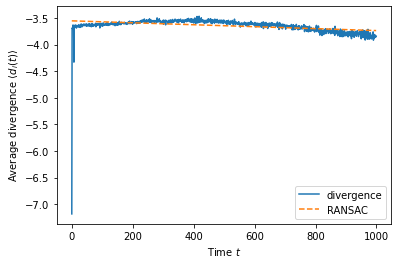

In [37]:
# Plot
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')

plt.plot(t, d, label='divergence')
plt.plot(t, coefs[1] +coefs[0]* t, '--', label='RANSAC')

plt.legend()
plt.show()